In [4]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import logging

sys.path.append(r"/Users/ysc/Desktop/imcProsperity/utils")

pd.options.mode.chained_assignment = None


In [18]:
from dataclasses import dataclass
from collections import defaultdict


POSITION_LIMIT = {
    'AMETHYSTS': 20,
    'STARFRUIT': 20
}


@dataclass
class result:
    """Class for simulation result"""
    import logging
    logging.basicConfig(format='%(message)s', level=logging.INFO)

    pnl: defaultdict
    transactions: pd.DataFrame
    mid_price: defaultdict
    position: defaultdict

    def summary(self, verbose=False):

        product_list = list(self.pnl.keys())
        product_list.remove('total')

        for k, v in self.pnl.items():
            logging.info(f" -> {k}: {v[-1]:.1f}")
        
        logging.info('\n')

        total_transaction_amt = len(self.transactions)        
        logging.info(f"# of transaction is {total_transaction_amt:d}")
        for k in product_list:
            buy = self.transactions[(self.transactions['Product'] == k) & (self.transactions['B/S'] == 'B')]
            sell = self.transactions[(self.transactions['Product'] == k) & (self.transactions['B/S'] == 'S')]
            total_v = len(buy) + len(sell)
            logging.info(f" -> {k}: B({len(buy):>3d}) + S({len(sell):>3d})")

        if not verbose:
            fig, ax = plt.subplots(1, 1)
            legends = []
            for k, v in self.pnl.items():
                ax.set_title("PnL")
                ax.plot(v)
                legends.append(k)
            ax.legend(legends)

        else:
            nrow = len(self.pnl) - 1
            fig, axs = plt.subplots(nrow, 2, figsize=(20, 12))
            for i, (k, v) in enumerate(self.pnl.items()):
                if k != 'total':
                    axs[i][0].set_title(k)
                    axs[i][0].plot(v)   
                    axs[i][0].legend(["Pnl"])
              
                    axs[i][1].set_title(k)
                    axs[i][1].plot(self.position[k])
                    ax2 = axs[i][1].twinx()
                    ax2.plot(self.mid_price[k], c='orange', alpha=0.5)
                    axs[i][1].set_ylim([-POSITION_LIMIT[k], POSITION_LIMIT[k]])


class Simulator:

    def __init__(self, scenario_path=None, df=None):

        if df is not None:
            self.df = df
        elif scenario_path is not None:
            self.df = pd.read_csv(scenario_path, sep=';')
    
        self.product = self.df['product'].unique().tolist()
        self.last_price_ = defaultdict(list)

        self.traderdata = ""
        self.timestamp = sorted(self.df['timestamp'].unique())
        self.order_depths_ = dict()
        self.own_trades_ = dict()
        self.listings_ = dict()
        self.market_trades_ = dict()
        self.position_ = defaultdict(lambda: [0])
        self.observations_ = dict() 
        self.pnl_ = defaultdict(lambda: [0])
        self.cost_basis_ = defaultdict(float)
        self.records = pd.DataFrame(columns=['TimeStamp', 'B/S', 'Quantity', "Product", 'Price'])


    def _clear(self):
        self.order_depths_.clear()
        self.own_trades_.clear()
        self.listings_.clear()
        self.market_trades_.clear()
        self.observations_.clear() 


    def _breach_or_not(self):
        for k, v in POSITION_LIMIT.items():
            if abs(self.position_[k][-1]) > v:
                return True
        return False


    def _settle(self, orders, timestamp):

        for product in self.product:
            
            new_position = self.position_[product][-1]

            if product in orders:
                
                order_depth = self.order_depths_[product]
                order = orders[product]

                sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
                sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)

                for o in order:
                    price, quantity = o.price, o.quantity

                    if quantity > 0:
                        for p, vol in sorted_sell_orders:
                            p, vol = int(p), int(vol)
                            if p <= price and quantity > 0:
                                done = min(quantity, abs(vol))
                                quantity -= done
                                new_position += done 
                                if product not in self.own_trades_:
                                    self.own_trades_[product] = [datamodel.Trade(product, p, done, self.traderdata, "", timestamp)]
                                else:
                                    self.own_trades_[product].append(datamodel.Trade(product, p, done, self.traderdata, "", timestamp))

                                self.cost_basis_[product] -= done * p

                                self.records.loc[len(self.records)] = timestamp, 'B', done, product, p

                    elif quantity < 0:
                        for p, vol in sorted_buy_orders:
                            p, vol = int(p), int(vol)
                            if p >= price and quantity < 0:
                                done = min(abs(quantity), vol)
                                quantity += done
                                new_position -= done 
                                if product not in self.own_trades_:
                                    self.own_trades_[product] = [datamodel.Trade(product, p, -done, "", self.traderdata, timestamp)]
                                else:
                                    self.own_trades_[product].append(datamodel.Trade(product, p, -done, "", self.traderdata, timestamp))

                                self.cost_basis_[product] += done * p
                                self.records.loc[len(self.records)] = timestamp, 'S', done, product, p
            
            self.position_[product] += [new_position]
            self.pnl_[product] += [ self.cost_basis_[product] + self.last_price_[product][-1] * self.position_[product][-1] ]

        self.pnl_['total'] += [ sum(self.pnl_[product][-1] for product in self.product) ]


    def simulate(self, Trader):

        for timestamp_ in self.timestamp:
            
            self._clear()

            tmp = self.df[self.df['timestamp'] == timestamp_]
            for _, row in tmp.iterrows():

                product_ = row['product']
                self.last_price_[product_] += [row['mid_price']]

                self.listings_[product_] = datamodel.Listing(product_, product_, 'SEASHELLS')
                self.order_depths_[product_] = datamodel.OrderDepth()

                dict_ = dict()
                for i in (1, 2, 3):
                    if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
                        dict_[row[f'bid_price_{i}']] = row[f'bid_volume_{i}']
                self.order_depths_[product_].buy_orders = dict_
                
                dict_ = dict()
                for i in (1, 2, 3):
                    if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
                        dict_[row[f'ask_price_{i}']] = -row[f'ask_volume_{i}']
                self.order_depths_[product_].sell_orders = dict_

            position__ = {k: v[-1] for k, v in self.position_.items()}

            tradingstate_ = datamodel.TradingState("", timestamp_, self.listings_, self.order_depths_, self.own_trades_, self.market_trades_, position__, self.observations_)

            orders, _, name = Trader.run(tradingstate_)

            self._settle(orders, timestamp_)

            if self._breach_or_not():
                return f"Breach Occurs at timestamp {timestamp_}"
        
        return result(self.pnl_, self.records, self.last_price_, self.position_)

In [524]:
import datamodel
from datamodel import OrderDepth, UserId, TradingState, Order

class Trader:

    LIMIT = {
        'AMETHYSTS': 20,
        'STARFRUIT': 20
    }

    starfruit_price_history = []
    starfruit_initial_price = 5000
    ma_window_size = 10
    positive_cnt = []

    @staticmethod
    def calculate_wavg_midprice(order_depth):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
        total_volume = 0
        wavg_price = 0
        for p, vol in sorted_buy_orders:
            wavg_price += p * vol
            total_volume += vol
        for p, vol in sorted_sell_orders:
            vol = abs(vol)
            wavg_price += p * vol
            total_volume += vol
        wavg_price /= total_volume
        return wavg_price

    @staticmethod
    def calculate_barrier_price(order_depth, barrier=10):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
        buy_p_, sell_p_ = -1, -1
        buy_vol_, sell_vol_ = 0, 0
        for p, vol in sorted_buy_orders:
            if vol >= barrier:
                buy_p_, buy_vol_ = p, vol
                break
            elif vol > buy_vol_:
                buy_p_, buy_vol_ = p, vol
        for p, vol in sorted_sell_orders:
            vol = abs(vol)
            if vol >= barrier:
                sell_p_, sell_vol_ = p, vol
                break
            elif vol > sell_vol_:
                sell_p_, sell_vol_ = p, vol
        return buy_p_, sell_p_



    def run(self, state):

        result = {}
        idx = state.timestamp // 100

        for product in state.order_depths:

            current_position = state.position.get(product, 0)
            order_depth = state.order_depths[product]
            orders = []

            if product == "AMETHYSTS":

                sell_capacity = - self.LIMIT[product] - current_position
                buy_capacity = self.LIMIT[product] - current_position

                if sell_capacity < 0:
                    orders.append(Order(product, 10001, sell_capacity))
                if buy_capacity > 0:
                    orders.append(Order(product, 9999, buy_capacity))

            elif product == "STARFRUIT":

                wavg_price = self.calculate_wavg_midprice(order_depth)

                # self.starfruit_price_history.append(wavg_price)

                # ll = min(self.ma_window_size, len(self.starfruit_price_history))
                # ma_price = 0
                # for i in range(1, ll + 1):
                #     ma_price += self.starfruit_price_history[-i]
                # ma_price = ma_price / ll


                if idx <= 10000:

                    sell_capacity = - self.LIMIT[product] - current_position
                    buy_capacity = self.LIMIT[product] - current_position
                    
                    if abs(sell_capacity) <= 10:
                        sell_margin, buy_margin = 1, 0
                    elif abs(buy_capacity) <= 10:
                        sell_margin, buy_margin = 0, 1
                    else:
                        sell_margin, buy_margin = 1, 1

                    

                wavg = round(wavg_price, 0)
                if sell_capacity < 0:
                    sell_capacity = int(0.5 * sell_capacity) - sell_capacity % 2 
                    orders.append(Order(product, wavg + sell_margin, sell_capacity))
                if buy_capacity > 0:
                    buy_capacity = int(0.5 * buy_capacity) + buy_capacity % 2
                    orders.append(Order(product, wavg - buy_margin, buy_capacity))

            result[product] = orders

        return result, None, "Taeja"

 -> AMETHYSTS: 130.0
 -> STARFRUIT: 117.0
 -> total: 247.0


# of transaction is 35
 -> AMETHYSTS: B(  7) + S( 13)
 -> STARFRUIT: B(  5) + S( 10)


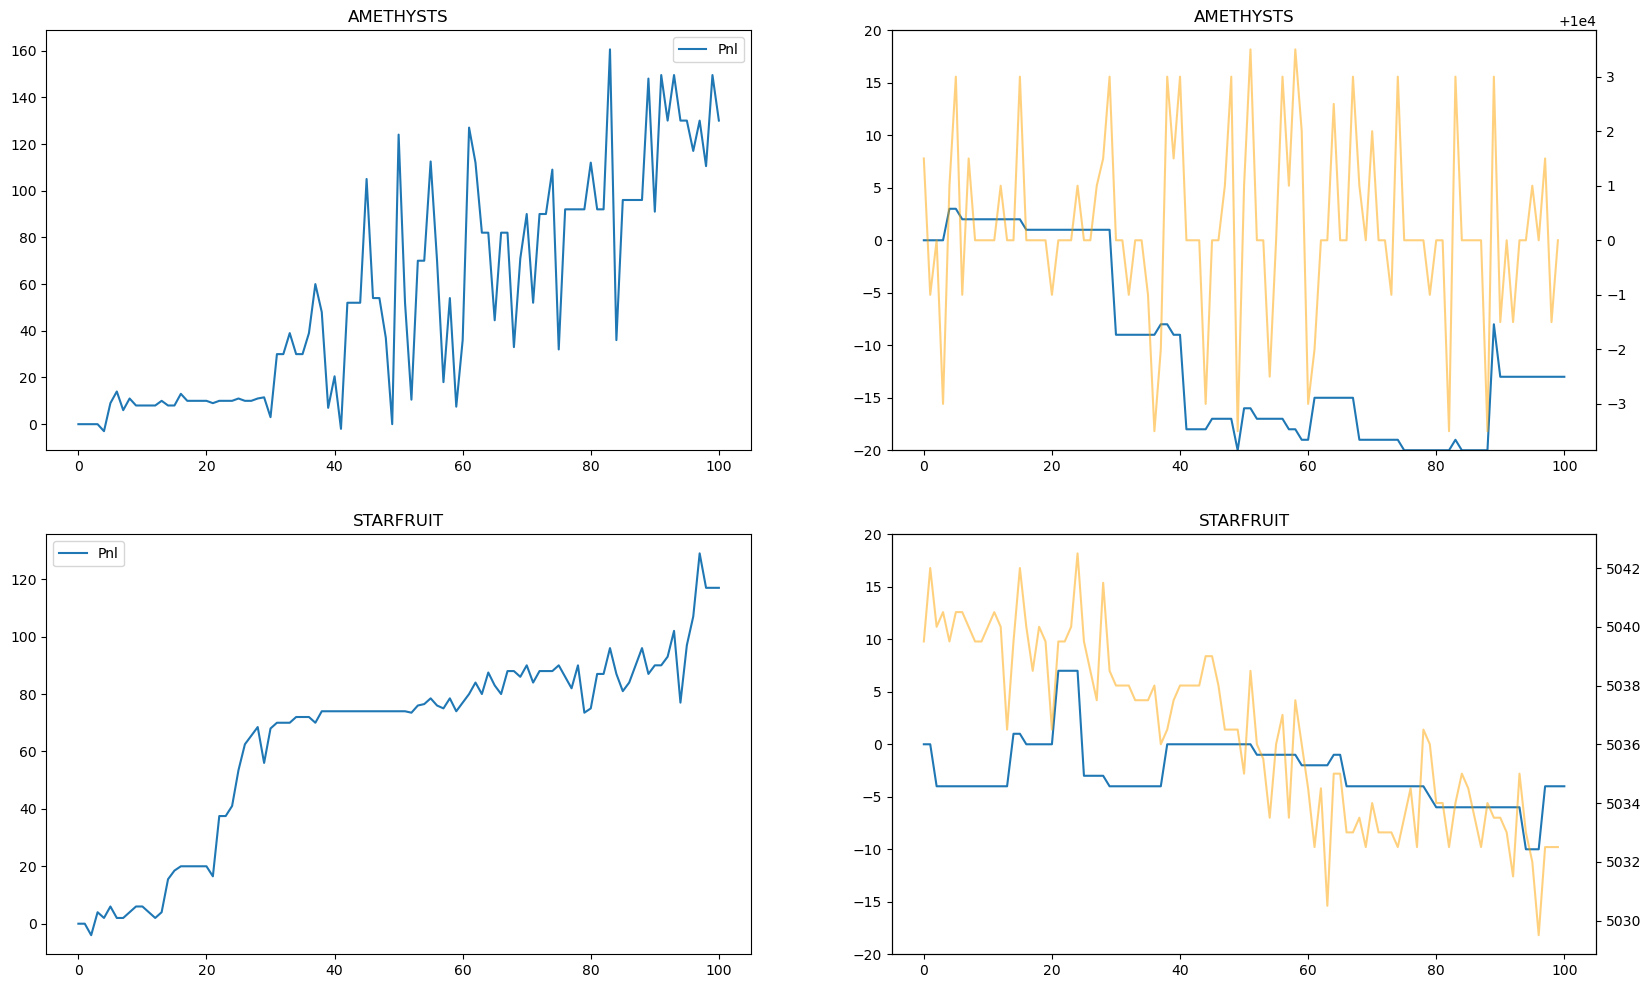

In [542]:
day = 0
# simulator = Simulator(rf"/Users/ysc/Desktop/imcProsperity/round1/data/prices_round_1_day_{day}.csv")
df = pd.read_csv(rf"/Users/ysc/Desktop/imcProsperity/round1/data/prices_round_1_day_{day}.csv", sep=';')[:200]
simulator = Simulator(df=df)
trader1 = Trader()
res = simulator.simulate(trader1)
res.summary(verbose=True)

In [544]:
day = 0
product = "STARFRUIT"

df = pd.read_csv(rf"/Users/ysc/Desktop/imcProsperity/round1/data/prices_round_1_day_{day}.csv", sep=';')
df = df[df['product'] == product]
df.reset_index(inplace=True)

In [547]:
m_window = 10

N=1000

starfruit_price_history = df['mid_price'].values
ma = []

for i in range(len(starfruit_price_history)):
        ma.append( int(starfruit_price_history[max(0, i-m_window+1):i+1].mean()) )
        

fig, ax = plt.subplots(figsize=(15, 8))
# ax.plot(df['mid_price'].values[:N])
ax.plot(ma[:N])

for idx, row in df[:N].iterrows():
    for i in (1, 2, 3):
        if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
                ax.scatter(idx, row[f'bid_price_{i}'], c='blue', s=row[f'bid_volume_{i}'])
    for i in (1, 2, 3):
        if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
                ax.scatter(idx, row[f'ask_price_{i}'], c='red', s=row[f'ask_volume_{i}'])

In [268]:
df

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
1,-1,0,STARFRUIT,5045,1,5040.0,31.0,NaN,NaN,5047,31,NaN,NaN,NaN,NaN,5046.0,0.0
2,-1,100,STARFRUIT,5040,24,NaN,NaN,NaN,NaN,5046,2,5047.0,22.0,NaN,NaN,5043.0,0.0
5,-1,200,STARFRUIT,5041,2,5040.0,20.0,NaN,NaN,5047,20,NaN,NaN,NaN,NaN,5044.0,0.0
7,-1,300,STARFRUIT,5040,31,NaN,NaN,NaN,NaN,5046,2,5047.0,29.0,NaN,NaN,5043.0,0.0
9,-1,400,STARFRUIT,5039,27,NaN,NaN,NaN,NaN,5046,27,NaN,NaN,NaN,NaN,5042.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19991,-1,999500,STARFRUIT,5041,2,5040.0,5.0,5037.0,31.0,5042,8,5044.0,31.0,NaN,NaN,5041.5,0.0
19992,-1,999600,STARFRUIT,5040,5,5037.0,30.0,NaN,NaN,5044,30,NaN,NaN,NaN,NaN,5042.0,0.0
19994,-1,999700,STARFRUIT,5037,26,NaN,NaN,NaN,NaN,5044,26,NaN,NaN,NaN,NaN,5040.5,0.0
19996,-1,999800,STARFRUIT,5036,20,NaN,NaN,NaN,NaN,5043,20,NaN,NaN,NaN,NaN,5039.5,0.0


In [111]:
np.sum(df['mid_price'].values - ma - 1 > 0)

1497

In [226]:
df.reset_index(inplace=True)
df

,index,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,-2,0,STARFRUIT,4997,26,NaN,NaN,NaN,NaN,5003,26,NaN,NaN,NaN,NaN,5000.0,0.0
1,3,-2,100,STARFRUIT,5000,5,4998.0,6.0,4997.0,20.0,5004,20,NaN,NaN,NaN,NaN,5002.0,0.0
2,4,-2,200,STARFRUIT,4997,1,4996.0,30.0,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,5000.0,0.0
3,7,-2,300,STARFRUIT,4996,27,NaN,NaN,NaN,NaN,5003,27,NaN,NaN,NaN,NaN,4999.5,0.0
4,9,-2,400,STARFRUIT,4995,20,NaN,NaN,NaN,NaN,5002,20,NaN,NaN,NaN,NaN,4998.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19990,-2,999500,STARFRUIT,5041,2,5040.0,24.0,NaN,NaN,5047,26,NaN,NaN,NaN,NaN,5044.0,0.0
9996,19993,-2,999600,STARFRUIT,5040,30,NaN,NaN,NaN,NaN,5047,30,NaN,NaN,NaN,NaN,5043.5,0.0
9997,19994,-2,999700,STARFRUIT,5040,22,NaN,NaN,NaN,NaN,5047,22,NaN,NaN,NaN,NaN,5043.5,0.0
9998,19996,-2,999800,STARFRUIT,5041,1,5040.0,25.0,NaN,NaN,5045,3,5047.0,26.0,NaN,NaN,5043.0,0.0


In [228]:
len(ma)

10000

In [235]:
pnl = [0]

for i, row in df.iterrows():

    pnl_ = 0
    for i in (1, 2, 3):
        if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
            if row[f'bid_price_{i}'] >= int(ma[i]) + 1:
                pnl_ += (row[f'bid_price_{i}'] - int(ma[i]))
    
    for i in (1, 2, 3):
        if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
            if row[f'ask_price_{i}'] <= int(ma[i]) - 1:
                pnl_ += (int(ma[i]) - row[f'ask_price_{i}'])

    print(pnl_)

    pnl += [ pnl[0] + pnl_ ]


0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
0
0
0
0
1
0
0
0
0
0
0
0
0
2
0
2
2
0
0
0
2
0
0
2
0
0
0
1
0
0
0
2
0
0
0
0
1
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
1
0
0
0
0
0
3
0
0
0
0
0
0
0
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
3
0
0
0
0
0
0
0
4
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
3
0
0
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
2
0
0
1
0
0
0
2
7
1
1
4.0
2
3
10.0
3
7.0
3
9.0
4.0
7.0
2
4.0
2
2
7.0
2
5.0
3
3
3
4
8.0
5
5
8.0
3
4
3
3
3
6.0
4
13.0
4
4
6.0
3
6.0
3
4.0
4.0
4.0
11.0
7.0
5.0
12.0
2
2
2
3
3
4
4
15.0
10.0
6.0
3
3
10.0
4
6.0
11.0
4
3
3
4
17.0
4
4
4
8.0
4
4
4
3
6.0
4
5
4
4
4
7.0
11.0
9.0
4.0
5.0
2
2
2
1
7
1
1
1
1
8.0
2
2
5.0
1
2
2
2
3
3
3
11.0
4
4
4
3
3
3
3
6.0
6.0
3
4
4
4
7.0
3
11.0
3
2
2
5.0
2
2
2
4.0
10.0
2
2
3
2
8.0
2
2
2
2
3
11.0
3
4
4
4
9.0
16.0
4
4
13.0
11.0
4
4
4
9.0
5
5
5
10.0
10.0
13.0
5
11.0
5

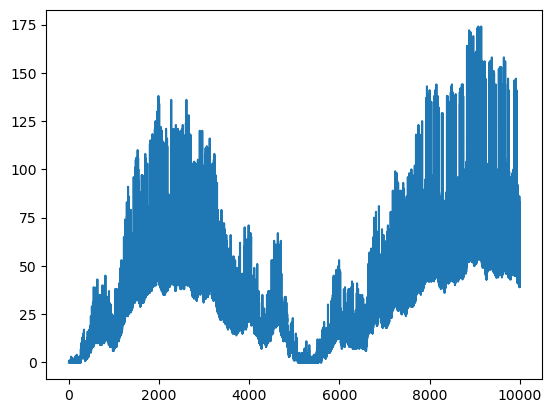

In [234]:
plt.plot(pnl)